<a href="https://colab.research.google.com/github/gabrielborja/python_data_analysis/blob/main/real_state_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Real State Analytics

Real state data from apartments for sale in Quito - Ecuador can be obtained from the following link [here](https://www.properati.com.ec/s/la-carolina/departamento/venta/m2:60-70_habitaciones:1/?sort=published_on_desc)

## Uploading packages and data

In [1]:
#Importing HTTP libraries
import requests
import pprint
from bs4 import BeautifulSoup as bs

In [2]:
#Importing data manipulation packages
import numpy as np
import pandas as pd
from time import sleep
from random import randint

##Retrieving data from URL

In [ ]:
#class requests.Response
#Response.elapsed, Response.encoding, Response.headers, Response.json, Response.status_code, Response.text, Response.url

In [3]:
#Create a function to retrieve data from given URL
def get_url(url):
  """Retrieve data from given URL and return a dataframe"""
  
  #Get data and parse with BeautifulSoup
  try:
    response = requests.get(url)
    print(response)
    #pprint.pprint(response.text[:200]) #Print first 200 char from HTML.
    soup = bs(response.text, 'html.parser')

    #Save retrieved data to lists
    d1_names = [i.text for i in soup.find_all(class_ ='bwJAej')]
    d1_location = [i.text for i in soup.find_all(class_ = 'fqaBNm')]
    d1_prices = [i.text for i in soup.find_all(class_ ='bZCCaW')]
    d1_rooms = [i.span.text for i in soup.find_all(class_ = 'fgcFIO') if 'habitaci' in i.text]
    d1_bathrooms = [i.text for i in soup.find_all('span') if 'baño' in i.text]
    d1_sqr_meters = [i.text for i in soup.find_all('span') if 'm²' in i.text]
    d1_seller_names = [i.text for i in soup.find_all(class_ = 'seller-name')]
    d1_times = [i['datetime'] for i in soup.find_all('time')]
    
    #Save data to dataframe
    df = pd.DataFrame()
    df = df.assign(date=d1_times, name=d1_names, location=d1_location,
                   price=d1_prices, rooms=d1_rooms, bathrooms=d1_bathrooms,
                   sqr_meters=d1_sqr_meters, seller=d1_seller_names)
    return df

  except requests.exceptions.RequestException as e:
    print(e)

In [ ]:
#Retrive data from URL and create a dataframe of apartments in Quito
#url = 'https://www.properati.com.ec/s/la-carolina/departamento/venta/m2:50-150_habitaciones:1_ba%C3%B1os:1,2,3_publicados:ultimos-7-dias/?sort=published_on_desc&page1'
#url = 'https://www.properati.com.ec/s/la-carolina/departamento/venta/publicados:ultimos-365-dias_m2:50-150_habitaciones:1,2,3_ba%C3%B1os:1,2,3/?sort=published_on_desc&page=12'
#url = 'https://www.properati.com.ec/s/bellavista-inaquito/departamento/venta/publicados:ultimos-365-dias_m2:50-150_habitaciones:1,2,3_ba%C3%B1os:1,2,3/?sort=published_on_desc'

#df1 = get_url(url)

In [22]:
#Scraping apartments from mulitple URLs and saving to a list
data = []
url = 'https://www.properati.com.ec/s/inaquito/departamento/venta/publicados:ultimos-365-dias_m2:23-500_habitaciones:1,2,3_ba%C3%B1os:1,2,3/?sort=published_on_desc&page='

for i in range(42, 47):
  page = url + str(i)
  data.append(get_url(page))
  sleep(randint(4,10))


<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [25]:
#Printing dataframes inside list
data[4].tail()

,date,name,location,price,rooms,bathrooms,sqr_meters,seller
23,2020-10-29T00:00:00.000Z,Departamento en La Carolina,"La Carolina, Iñaquito, Centro Norte, Quito, Pi...",$ 155.000,3 habitaciones,3 baños,122 m²,Genma Cabezas
24,2020-10-29T00:00:00.000Z,Departamento en La Carolina,"La Carolina, Iñaquito, Centro Norte, Quito, Pi...",$ 155.000,3 habitaciones,3 baños,121 m²,Genma Cabezas
25,2020-10-29T00:00:00.000Z,Departamento en Gonzalez Suarez,"Gonzalez Suarez, Iñaquito, Centro Norte, Quito...",$ 179.000,3 habitaciones,2 baños,155 m²,Genma Cabezas
26,2020-09-08T00:00:00.000Z,Satori,"La Carolina, Iñaquito, Centro Norte, Quito, Pi...",$ 221.426,3 habitaciones,3 baños,113 m²,Properati
27,2020-07-24T00:00:00.000Z,Milo´s House,"La Carolina, Iñaquito, Centro Norte, Quito, Pi...",$ 179.530,3 habitaciones,3 baños,117 m²,Properati


In [ ]:
#Concatenating dataframes from list
df1 = pd.concat(objs=[i for i in data], ignore_index=True)
df1.shape #==> from page 1 to 46

In [31]:
#Exporting to excel into local disk
from google.colab import files
df1.to_excel('2021_07_20_inaquito.xlsx', index=False) #==> Excluding index from file
files.download('2021_07_20_inaquito.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Data Cleaning

In [ ]:
#Importing necessary packages
import numpy as np
import pandas as pd

In [32]:
#Remove previous versions of the uploaded file
!rm 2021_07_20_inaquito.xlsx

In [33]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

Saving 2021_07_20_inaquito.xlsx to 2021_07_20_inaquito.xlsx


In [35]:
#Storing dataset in a Pandas Dataframe
import io
df1 = pd.read_excel(io.BytesIO(uploaded1['2021_07_20_inaquito.xlsx']), parse_dates=True)

In [36]:
#Checking the dataframe information
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        1288 non-null   object
 1   name        1288 non-null   object
 2   location    1288 non-null   object
 3   price       1288 non-null   object
 4   rooms       1288 non-null   object
 5   bathrooms   1288 non-null   object
 6   sqr_meters  1288 non-null   object
 7   seller      1288 non-null   object
dtypes: object(8)
memory usage: 80.6+ KB


In [37]:
#Checking the dataframe tail
df1.tail()

,date,name,location,price,rooms,bathrooms,sqr_meters,seller
1283,2020-10-29T00:00:00.000Z,Departamento en La Carolina,"La Carolina, Iñaquito, Centro Norte, Quito, Pi...",$ 155.000,3 habitaciones,3 baños,122 m²,Genma Cabezas
1284,2020-10-29T00:00:00.000Z,Departamento en La Carolina,"La Carolina, Iñaquito, Centro Norte, Quito, Pi...",$ 155.000,3 habitaciones,3 baños,121 m²,Genma Cabezas
1285,2020-10-29T00:00:00.000Z,Departamento en Gonzalez Suarez,"Gonzalez Suarez, Iñaquito, Centro Norte, Quito...",$ 179.000,3 habitaciones,2 baños,155 m²,Genma Cabezas
1286,2020-09-08T00:00:00.000Z,Satori,"La Carolina, Iñaquito, Centro Norte, Quito, Pi...",$ 221.426,3 habitaciones,3 baños,113 m²,Properati
1287,2020-07-24T00:00:00.000Z,Milo´s House,"La Carolina, Iñaquito, Centro Norte, Quito, Pi...",$ 179.530,3 habitaciones,3 baños,117 m²,Properati


In [38]:
#Converting date column to datetime
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_convert('America/Guayaquil')

In [39]:
#Extracting city and zone from location
df1['city'] = [i[3].strip() for i in df1['location'].str.split(',')]
df1['zone'] = [i[0].strip() for i in df1['location'].str.split(',')]

In [40]:
#Eliminating $ and . from price and convert to int
df1['price'] = df1['price'].str.replace('\$*\.*', '', regex=True)
df1['price'] = df1['price'].astype(int)

In [41]:
#Converting number of rooms to int
df1['rooms'] = [i[0].strip() for i in df1['rooms'].str.split(' ')]
df1['rooms'] = df1['rooms'].astype(int)

In [42]:
#Converting bathrooms to int
df1['bathrooms'] = [i[0].strip() for i in df1['bathrooms'].str.split(' ')]
df1['bathrooms'] = df1['bathrooms'].astype(int)

In [43]:
#Converting square meters to int
df1['sqr_meters'] = [i[0].strip() for i in df1['sqr_meters'].str.split(' ')]
df1['sqr_meters'] = df1['sqr_meters'].astype(int)

In [44]:
#Checking unique values for square meters
df1['sqr_meters'].unique()

array([110, 100,  60, 113,  62, 107,  86, 266, 192,  98,  56, 115, 198,
        85,  70, 173,  49, 490,  90, 137, 128, 111, 160, 121,  84,  81,
       264,  76,  67, 103, 144, 180, 109,  74, 148, 130, 155,  92,  55,
       114,  27, 150, 102, 117, 133, 163, 104, 220,  78, 210,  63, 108,
        88, 184,  25,  71,  94,  80,  52, 175,  87, 145,  89,  44,  83,
       166, 116, 185,  53, 105,  75, 129, 248, 120,  59,  65, 235, 127,
        93, 200,  50, 190,  30,  45,  24, 191, 201, 330, 170, 250,  97,
       247,  51,  82, 211, 293,  95, 178, 254, 315, 340,  61, 118,  64,
        68,  72, 169,  77,  79,  66, 188, 255, 218, 152,  69,  40, 122,
       500,  91,  99, 140, 135, 420, 142, 123,  57, 260,  47, 134,  28,
       232, 141, 154,  54, 106, 162, 164, 151, 101, 171, 119, 124, 131,
       223, 125,  58,  29, 336, 157, 138, 165, 112,  96, 143, 275, 348,
       168, 204, 126,  48,  38, 174, 233, 221,  73, 176, 149, 263, 240,
       225, 186,  46,  43, 287, 205, 234, 195, 161,  35, 230, 18

In [45]:
#Converting sellers to title case
df1['seller'] = df1['seller'].str.title()

In [46]:
#Rearranging order of columns
df1 = df1[['date', 'city', 'zone', 'name', 'seller', 'sqr_meters', 'rooms', 'bathrooms', 'price']]

In [47]:
#Checking the dataframe tail
df1.tail()

,date,city,zone,name,seller,sqr_meters,rooms,bathrooms,price
1283,2020-10-28 19:00:00-05:00,Quito,La Carolina,Departamento en La Carolina,Genma Cabezas,122,3,3,155000
1284,2020-10-28 19:00:00-05:00,Quito,La Carolina,Departamento en La Carolina,Genma Cabezas,121,3,3,155000
1285,2020-10-28 19:00:00-05:00,Quito,Gonzalez Suarez,Departamento en Gonzalez Suarez,Genma Cabezas,155,3,2,179000
1286,2020-09-07 19:00:00-05:00,Quito,La Carolina,Satori,Properati,113,3,3,221426
1287,2020-07-23 19:00:00-05:00,Quito,La Carolina,Milo´s House,Properati,117,3,3,179530


In [48]:
#Checking the dataframe info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype                            
---  ------      --------------  -----                            
 0   date        1288 non-null   datetime64[ns, America/Guayaquil]
 1   city        1288 non-null   object                           
 2   zone        1288 non-null   object                           
 3   name        1288 non-null   object                           
 4   seller      1288 non-null   object                           
 5   sqr_meters  1288 non-null   int64                            
 6   rooms       1288 non-null   int64                            
 7   bathrooms   1288 non-null   int64                            
 8   price       1288 non-null   int64                            
dtypes: datetime64[ns, America/Guayaquil](1), int64(4), object(4)
memory usage: 90.7+ KB


In [49]:
#Exporting to excel into local disk
from google.colab import files
df1.to_csv('2021_07_20_inaquito.csv', index=False) #==> Excluding index from file
files.download('2021_07_20_inaquito.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Apartments EDA

In [ ]:
#Plotly --upgrade
!pip install plotly --upgrade

In [ ]:
#Removing previous versions of the file
!rm 2021_07_17_la_carolina.csv

In [ ]:
#Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import seaborn as sns
import plotly.express as px

In [ ]:
#Customizing data visualization style
sns.set_theme(rc = {'figure.figsize': (8, 4)})

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

Saving 2021_07_17_la_carolina.csv to 2021_07_17_la_carolina.csv


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df1 = pd.read_csv(io.BytesIO(uploaded1['2021_07_17_la_carolina.csv']), parse_dates=True)

In [ ]:
#Checking the dataframe info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        332 non-null    object
 1   city        332 non-null    object
 2   zone        332 non-null    object
 3   name        332 non-null    object
 4   seller      332 non-null    object
 5   sqr_meters  332 non-null    int64 
 6   rooms       332 non-null    int64 
 7   bathrooms   332 non-null    int64 
 8   price       332 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 23.5+ KB


In [ ]:
#Convert date column to datetime
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_convert('America/Guayaquil')

In [ ]:
#Selecting essential columns and saving to new dataframe
df1_apa = df1[['date', 'sqr_meters', 'rooms', 'bathrooms', 'price']].copy()
df1_apa.tail()

,date,sqr_meters,rooms,bathrooms,price
327,2020-10-28 19:00:00-05:00,121,3,3,155000
328,2020-10-28 19:00:00-05:00,76,3,2,99000
329,2020-10-28 19:00:00-05:00,86,2,3,146000
330,2020-09-07 19:00:00-05:00,113,3,3,221426
331,2020-07-23 19:00:00-05:00,117,3,3,179530


In [ ]:
#Assigning columns as categorical data
df1_apa['rooms'] = df1_apa['rooms'].astype("category")
df1_apa['bathrooms'] = df1_apa['bathrooms'].astype("category")

In [ ]:
#Performing descriptipe statistics
df1_apa.describe()

,sqr_meters,price
count,332.000000,332.000000
mean,86.768072,143980.602410
std,24.744565,46872.409205
min,50.000000,49000.000000
25%,66.000000,115000.000000
50%,82.500000,133910.500000
75%,103.250000,167704.500000
max,150.000000,400050.000000


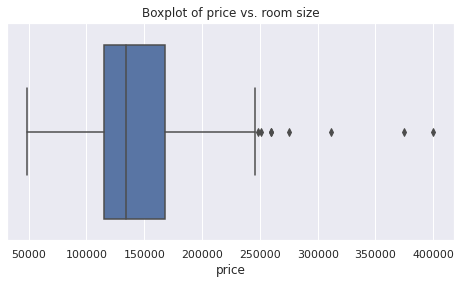

In [ ]:
#Plotting the box plot of price
sns.boxplot(x='price', data=df1_apa)
plt.title('Boxplot of price vs. room size')
plt.show()

In [ ]:
#Calculating outlier threshold
iqr = (df1_apa['price'].quantile(0.75) - df1_apa['price'].quantile(0.25))
outl = (df1_apa['price'].quantile(0.75) + 1.5*iqr) #==> Third quartile + 1.5*IQR
print(iqr, outl)

52704.5 246761.25


In [ ]:
#Dropping outliers from dataset
df1_apa = df1_apa[df1_apa['price']<outl].reset_index(drop=True)
df1_apa.shape

(324, 5)

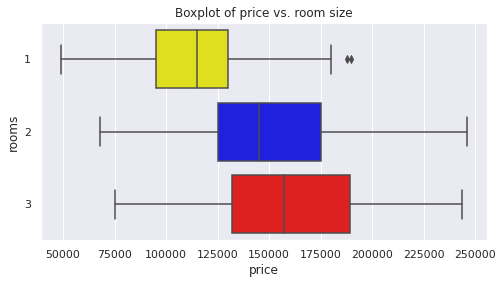

In [ ]:
#Plotting the box plot of price
sns.boxplot(x='price', y='rooms', data=df1_apa, palette=['#ffff00', '#0000ff', '#ff0000'])
plt.title('Boxplot of price vs. room size')
plt.show()

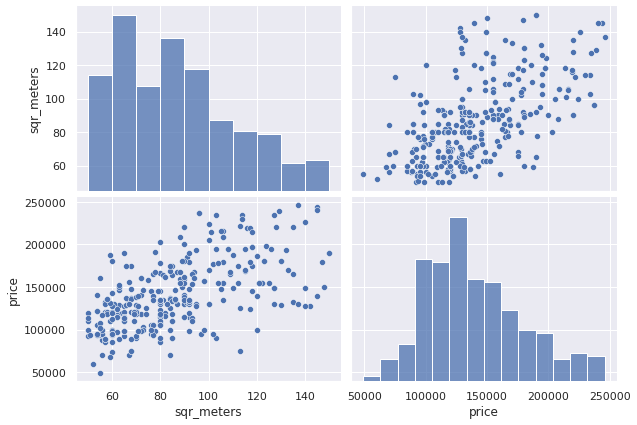

In [ ]:
#Plotting pairplot of price vs square meters
sns.pairplot(data=df1_apa, height=3, aspect=1.5)
plt.show()

In [ ]:
#Exporting to excel into local disk
from google.colab import files
df1_apa.to_csv('2021_07_19_apartments.csv', index=False) #==> Excluding index from file
files.download('2021_07_19_apartments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Grouping by year, month and rooms
df1_grouped = df1_apa.copy()
df1_grouped = df1_grouped.assign(price_sqr = round((df1_grouped['price']/df1_grouped['sqr_meters']), 2),
                                 year = df1_grouped['date'].dt.year,
                                 month = df1_grouped['date'].dt.month)
df1_grouped = df1_grouped.groupby(['year', 'month', 'rooms']).agg(price = ('price', 'mean'), price_sqr = ('price_sqr', 'mean')).reset_index()
df1_grouped.tail()

,year,month,rooms,price,price_sqr
61,2021,11,2,NaN,NaN
62,2021,11,3,NaN,NaN
63,2021,12,1,NaN,NaN
64,2021,12,2,NaN,NaN
65,2021,12,3,NaN,NaN


In [ ]:
#Plotting square meters vs price
@interact(rooms=[1,2,3])
def plot_scatter(rooms):
  sns.regplot(x='sqr_meters', y='price', data=df1_apa[df1_apa['rooms']==rooms], seed=1)
  plt.title(f'Scatterplot of {rooms} rooms Apartments')
  plt.show()

interactive(children=(Dropdown(description='rooms', options=(1, 2, 3), value=1), Output()), _dom_classes=('wid…

In [ ]:
#Plot the price vs time for different categories
@interact(year=[2020, 2021], rooms=df1_apa['rooms'].unique())
def plot_scatter(year, rooms):
  fig1_a = px.bar(data_frame=df1_grouped[(df1_grouped['year']==year) & (df1_grouped['rooms']==rooms)], x='month', y='price',
                  title='Apartments in Quito - La Carolina', width=900, height=400)
  fig1_a.show()

interactive(children=(Dropdown(description='year', options=(2020, 2021), value=2020), Dropdown(description='ro…

##Machine Learning modeling

###Uploading data

In [ ]:
#Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Customizing data visualization style
sns.set_theme(rc = {'figure.figsize': (12, 4)})

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

Saving 2021_07_19_apartments.csv to 2021_07_19_apartments.csv


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df1_ml = pd.read_csv(io.BytesIO(uploaded1['2021_07_19_apartments.csv']), parse_dates=True)

In [ ]:
#Dropping date column, assigning categorical type
df1_ml = df1_ml.drop(columns='date')
df1_ml['rooms'] = df1_ml['rooms'].astype("category")
df1_ml['bathrooms'] = df1_ml['bathrooms'].astype("category")
df1_ml.tail()

,sqr_meters,rooms,bathrooms,price
319,121,3,3,155000
320,76,3,2,99000
321,86,2,3,146000
322,113,3,3,221426
323,117,3,3,179530


###Linear Regression

In [ ]:
#Importing machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [ ]:
#Splitting the dataset into train and test
X = np.c_[df1_ml['sqr_meters'].to_numpy(), df1_ml['rooms'].to_numpy(), df1_ml['bathrooms'].to_numpy()]
X_train, X_test, y_train, y_test = train_test_split(X, np.array(df1_ml['price']), random_state=1)
print(X_train.shape, X_test.shape)

#lr = LinearRegression().fit(X_train, y_train)
#print(f'lr.coef_: {lr.coef_}, lr.intercept_: {lr.intercept_}')

(243, 3) (81, 3)


In [ ]:
#Preprocessing using 0-1 scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled[:5])
print(X_test_scaled[:5])

[[0.22 0.   0.  ]
 [0.42 0.   0.  ]
 [0.56 0.5  1.  ]
 [0.45 0.   0.5 ]
 [0.24 0.   0.5 ]]
[[0.13 0.   0.5 ]
 [0.48 0.5  0.5 ]
 [0.1  0.   0.5 ]
 [0.19 0.   0.  ]
 [0.13 0.   0.5 ]]


In [ ]:
#Performing Liner Regression on apartment prices
lr = LinearRegression().fit(X_train_scaled, y_train)
print(f'lr.coef_: {lr.coef_}, lr.intercept_: {lr.intercept_}')

lr.coef_: [56743.49336176  -358.5767255  49152.81300228], lr.intercept_: 90740.25334670303


In [ ]:
#Looking at the training set and test set performance
print(f'Training set score: {lr.score(X_train_scaled, y_train)}')
print(f'Training test score: {lr.score(X_test_scaled, y_test)}')

Training set score: 0.44162440822932986
Training test score: 0.3396124340805059
